Import some library code


*   `tensorflow` is the machine learning library we're using
*   `os` helps us interact with files and folders
*   `matplotlib` is for displaying charts and images
*   `numpy` helps us work with data to prepare it for `tensorflow` and review it afterwards


In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

This code gets the data you will use to train your model: pictures of cats and dogs.


In [2]:
import tensorflow_datasets as tfds

(raw_training, raw_validation, raw_testing), metadata = tfds.load( name='cats_vs_dogs', split=[
    tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
    tfds.Split.TRAIN.subsplit(tfds.percent[80:90]),
    tfds.Split.TRAIN.subsplit(tfds.percent[90:])
    ], with_info=True, as_supervised=True)

2022-03-26 16:01:44.315288: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-26 16:01:44.315885: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.



This function takes an image and a label as inputs. The image is then converted into three sets of numbers representing the colours red, green, and blue for every pixel in the image. The combination of these colours can form any other colour. The red, green, and blue values are then converted from numbers between 0 and 255, to numbers between -1 and 1, as the model has been trained to work with values in that range. Finally, the image is resized based on the `IMAGE_SIZE` constant, to match the size the model was previously trained on. In this case, it's a 160 by 160 pixel square.


In [3]:
IMAGE_SIZE = 160

training_data = None

# Resize an image, and convert it into a form that tensorflow can read more easily 
def prep_image(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  return image, label

training_data = raw_training.map(prep_image)
validation_data = raw_validation.map(prep_image)
testing_data = raw_testing.map(prep_image)

These are versions of the functions from the previous project, so you can use them to test your model.

In [4]:
def get_image_from_url(image_url):
  # If the temporary test_image.jpg file already exists, 
  # delete it so a new one can be made.
  if os.path.exists('/root/.keras/datasets/test_image.jpg'):
    os.remove('/root/.keras/datasets/test_image.jpg')

  image_path = tf.keras.utils.get_file('test_image.jpg', origin=image_url)
  return image_path

def print_predictions(predictions):
    for (prediction, number) in zip(predictions[0], range(1, len(predictions[0])+1)):
      print('{}. {} {:.2f}%'.format(number, prediction[1], prediction[2]*100))

def predict_with_old_model(image_url):
  image_path = get_image_from_url(image_url)
  
  image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))

  plt.figure()
  plt.imshow(image)

  image = tf.keras.preprocessing.image.img_to_array(image)
  image = np.expand_dims(image, axis=0)
  
  prediction_result = original_model.predict(image, batch_size=1)
  predictions = tf.keras.applications.imagenet_utils.decode_predictions(prediction_result, top=15)

  print_predictions(predictions)

def predict_image(image_url):
  image_path = get_image_from_url(image_url)
  
  image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))

  plt.figure()
  plt.imshow(image)

  image = tf.keras.preprocessing.image.img_to_array(image)
  image = np.expand_dims(image, axis=0)
  
  prediction_result = model.predict(image, batch_size=1)
  labels = metadata.features['label'].names
  print(labels[prediction_result.argmin()])

Import and test the MobileNetV2 model that you will retrain. (Issues str not in decode fixed _conda install 'h5py==2.10.0'_)



1. matchstick 49.70%
2. pinwheel 8.62%
3. plunger 4.91%
4. syringe 3.78%
5. window_screen 2.28%
6. umbrella 1.87%
7. Chihuahua 1.87%
8. envelope 1.82%
9. missile 1.38%
10. lipstick 1.28%
11. projectile 1.15%
12. jigsaw_puzzle 1.14%
13. screwdriver 0.92%
14. space_shuttle 0.76%
15. German_shepherd 0.60%


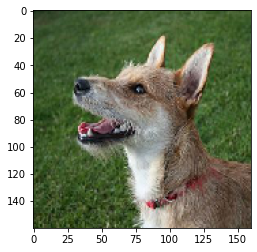

In [5]:
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
original_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE)
predict_with_old_model('https://dojo.soy/predict-dog')

In the cell below, split your images into training, validation, and testing data.

Add the new layers to the model, to allow it to be retrained.

Set up your training epochs and train the new layers of the model.

Use the `predict_image` function to test your model.